In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [6]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [7]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [8]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [9]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
data_string = f'thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
param_string = f'{data_string}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000'

In [10]:
model_file = os.path.join(file_dir, f'ising_model_light_group_{param_string}.pt')
model = torch.load(model_file, weights_only=False)

In [11]:
print( model.h.size() )
print( model.J.size() )

torch.Size([101, 31, 360])
torch.Size([101, 31, 360, 360])


In [12]:
mean_state = torch.load( os.path.join(file_dir, f'mean_state_{data_string}.pt'), weights_only=False )
print( mean_state.size() )
mean_state_product = torch.load( os.path.join(file_dir, f'mean_state_product_{data_string}.pt'), weights_only=False )
print( mean_state_product.size() )

torch.Size([31, 360])
torch.Size([31, 360, 360])


In [13]:
data_cov = isingmodellight.get_cov(state_mean=mean_state, state_product_mean=mean_state_product)
print( data_cov.size() )

torch.Size([31, 360, 360])


In [14]:
data_cov_inv = torch.linalg.inv(data_cov)
print( data_cov_inv.size() )

torch.Size([31, 360, 360])


In [15]:
J_mean = model.J.mean(dim=0)
print( J_mean.size() )

torch.Size([31, 360, 360])


In [16]:
J_cov_inv_corr = isingmodellight.get_pairwise_correlation_ut( mat1=data_cov_inv.unsqueeze(dim=0), mat2=model.J, epsilon=0.0 )
print( J_cov_inv_corr.size() )

torch.Size([101, 31])


In [17]:
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=J_cov_inv_corr.dtype, device=J_cov_inv_corr.device)
print( thresholds.size() )

torch.Size([31])


Text(0, 0.5, 'correlation between J and inverse covariance matrix of binarized data')

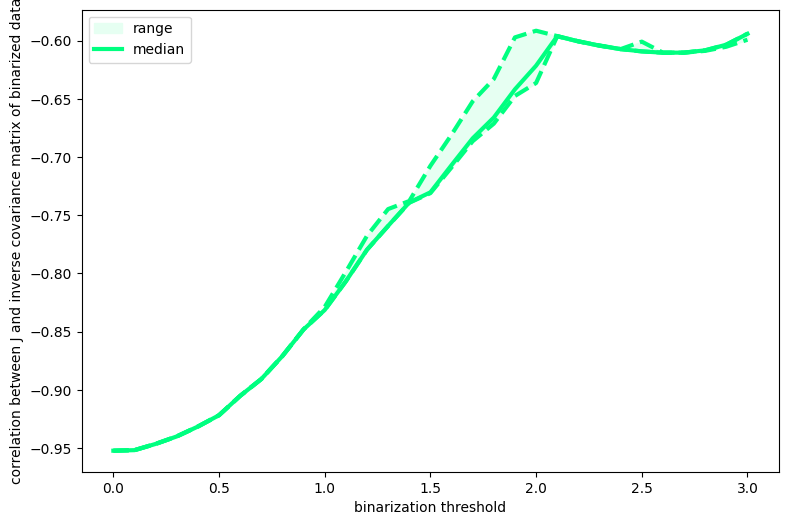

In [18]:
thresholds_np = depytorch(thresholds)
min_J_cov_inv_corr = depytorch( torch.min(J_cov_inv_corr, dim=0).values )
median_J_cov_inv_corr = depytorch( torch.median(J_cov_inv_corr, dim=0).values )
max_J_cov_inv_corr = depytorch( torch.max(J_cov_inv_corr, dim=0).values )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
cval = [0.0, 1.0, 0.5]
axs.fill_between( thresholds_np, min_J_cov_inv_corr, max_J_cov_inv_corr, color=[0.9+0.1*c for c in cval], label=f'range')
axs.plot( thresholds_np, min_J_cov_inv_corr, color=cval, linestyle='--', linewidth=line_width )
axs.plot( thresholds_np, max_J_cov_inv_corr, color=cval, linestyle='--', linewidth=line_width )
axs.plot( thresholds_np, median_J_cov_inv_corr, color=cval, linewidth=line_width, label=f'median' )
axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation between J and inverse covariance matrix of binarized data')

In [19]:
for target_threshold in [0.0, 1.0]:
    thresh_0_index = get_closest_match(values=thresholds, target=target_threshold)
    print(f'At threshold={target_threshold:.3g}, the correlations are in the range [{min_J_cov_inv_corr[thresh_0_index]:.3g}, {max_J_cov_inv_corr[thresh_0_index]:.3g}].')

At threshold=0, the correlations are in the range [-0.952, -0.952].
At threshold=1, the correlations are in the range [-0.831, -0.829].


In [20]:
num_nodes = model.J.size(dim=-1)
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products(num_nodes=num_nodes, device=model.J.device)
print( triu_rows.size(), triu_cols.size() )

torch.Size([64620]) torch.Size([64620])


Text(0.5, 1.0, 'threshold=1')

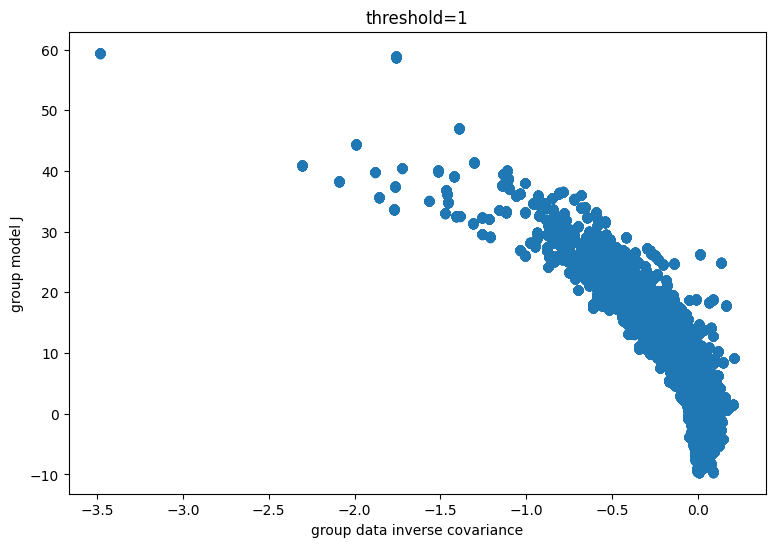

In [29]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
target_threshold = 1.0
thresh_index = get_closest_match(values=thresholds, target=target_threshold)
num_reps = model.J.size(dim=0)
data_cov_inv_triu_flat = data_cov_inv[thresh_index,triu_rows,triu_cols].unsqueeze(dim=0).repeat( (num_reps,1) ).flatten()
J_flat = model.J[:,thresh_index,triu_rows,triu_cols].flatten()
axs.scatter( depytorch(data_cov_inv_triu_flat), depytorch(J_flat) )
axs.set_xlabel('group data inverse covariance')
axs.set_ylabel('group model J')
axs.set_title(f'threshold={target_threshold:.3g}')

torch.return_types.linalg_lstsq(
solution=tensor([[-44.9935],
        [  0.3478]], device='cuda:0'),
residuals=tensor([308334.5000], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))
torch.Size([64620, 1])


Text(0.5, 1.0, 'threshold=1')

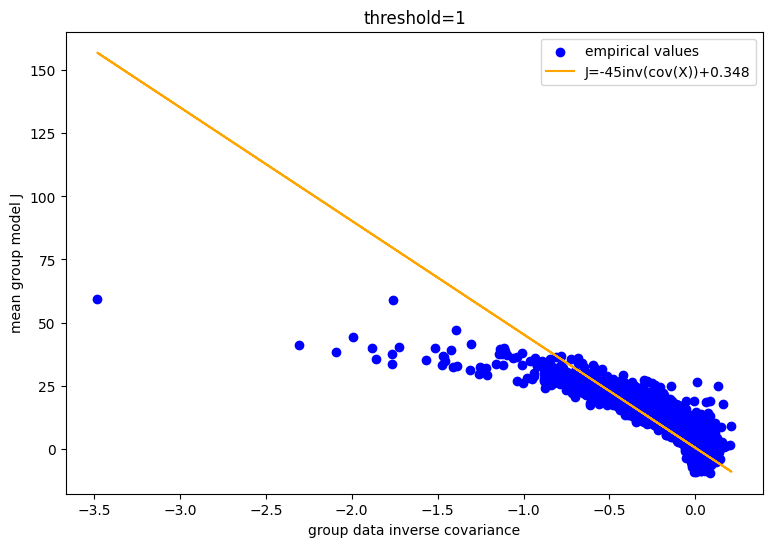

In [30]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
target_threshold = 1.0
thresh_index = get_closest_match(values=thresholds, target=target_threshold)
num_reps = model.J.size(dim=0)
data_cov_inv_triu = data_cov_inv[thresh_index,triu_rows,triu_cols]
J_mean_triu = model.J[:,thresh_index,triu_rows,triu_cols].mean(dim=0)
f_of_inv_cov = data_cov_inv_triu
ones_triu_shape = torch.ones_like(f_of_inv_cov)
f_of_inv_cov_and_one = torch.stack( (f_of_inv_cov, ones_triu_shape), dim=-1 )
lstsq_result = torch.linalg.lstsq( f_of_inv_cov_and_one, J_mean_triu.unsqueeze(dim=-1) )
print( lstsq_result )
J_pred = torch.matmul( f_of_inv_cov_and_one, lstsq_result.solution )
print( J_pred.size() )
f_of_inv_cov_np = depytorch(f_of_inv_cov)
axs.scatter( f_of_inv_cov_np, depytorch(J_mean_triu), color='blue', label='empirical values' )
axs.plot( f_of_inv_cov_np, depytorch(J_pred), color='orange', label=f'J={lstsq_result.solution[0,0]:.3g}inv(cov(X))+{lstsq_result.solution[1,0]:.3g}' )
axs.legend()
axs.set_xlabel('group data inverse covariance')
axs.set_ylabel('mean group model J')
axs.set_title(f'threshold={target_threshold:.3g}')

found pivot point inv(cov(X))=-0.00135, J=-1.8e-05
torch.return_types.linalg_lstsq(
solution=tensor([[60.8540]], device='cuda:0'),
residuals=tensor([245086.1719], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))


Text(0.5, 1.0, 'threshold=1')

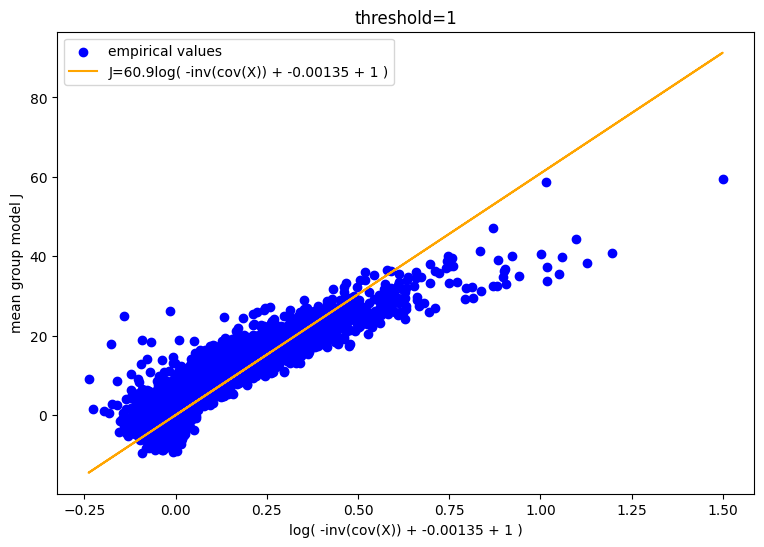

In [31]:
# Find the inverse covariance for which the corresponding J is closest to 0.
J_0_index = get_closest_match(values=J_mean_triu, target=0.0)
J_0 = J_mean_triu[J_0_index]
inv_cov_1 = data_cov_inv_triu[J_0_index]
print(f'found pivot point inv(cov(X))={inv_cov_1:.3g}, J={J_0:.3g}')
f_of_inv_cov = torch.log( -data_cov_inv_triu + inv_cov_1 + 1.0 )
f_of_inv_cov_col = f_of_inv_cov.unsqueeze(dim=-1)
J_mean_triu_col = J_mean_triu.unsqueeze(dim=-1)
lstsq_result = torch.linalg.lstsq(f_of_inv_cov_col, J_mean_triu_col)
print( lstsq_result )
J_pred = torch.matmul( f_of_inv_cov_col, lstsq_result.solution ).flatten()
# print( J_pred.size() )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
f_of_inv_cov_np = depytorch(f_of_inv_cov)
axs.scatter( f_of_inv_cov_np, depytorch(J_mean_triu), color='blue', label='empirical values' )
axs.plot( f_of_inv_cov_np, depytorch(J_pred), color='orange', label=f'J={lstsq_result.solution[0,0]:.3g}log( -inv(cov(X)) + {inv_cov_1:.3g} + 1 )' )
axs.legend()
axs.set_xlabel(f'log( -inv(cov(X)) + {inv_cov_1:.3g} + 1 )')
axs.set_ylabel('mean group model J')
axs.set_title(f'threshold={target_threshold:.3g}')

found pivot point inv(cov(X))=-0.00179, J=7.8e-06
torch.return_types.linalg_lstsq(
solution=tensor([[52.0983]], device='cuda:0'),
residuals=tensor([16481.1055], device='cuda:0'),
rank=tensor([], device='cuda:0', dtype=torch.int64),
singular_values=tensor([], device='cuda:0'))


Text(0.5, 1.0, 'threshold=0')

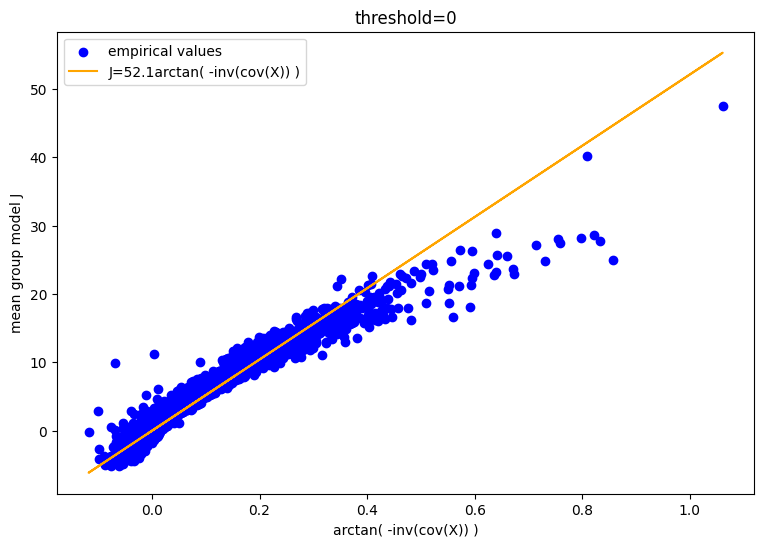

In [26]:
# Find the inverse covariance for which the corresponding J is closest to 0.
J_0_index = get_closest_match(values=J_mean_triu, target=0.0)
J_0 = J_mean_triu[J_0_index]
inv_cov_1 = data_cov_inv_triu[J_0_index]
print(f'found pivot point inv(cov(X))={inv_cov_1:.3g}, J={J_0:.3g}')
f_of_inv_cov = torch.atan( -data_cov_inv_triu )
f_of_inv_cov_col = f_of_inv_cov.unsqueeze(dim=-1)
J_mean_triu_col = J_mean_triu.unsqueeze(dim=-1)
lstsq_result = torch.linalg.lstsq(f_of_inv_cov_col, J_mean_triu_col)
print( lstsq_result )
J_pred = torch.matmul( f_of_inv_cov_col, lstsq_result.solution ).flatten()
# print( J_pred.size() )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
f_of_inv_cov_np = depytorch(f_of_inv_cov)
axs.scatter( f_of_inv_cov_np, depytorch(J_mean_triu), color='blue', label='empirical values' )
axs.plot( f_of_inv_cov_np, depytorch(J_pred), color='orange', label=f'J={lstsq_result.solution[0,0]:.3g}arctan( -inv(cov(X)) )' )
axs.legend()
axs.set_xlabel(f'arctan( -inv(cov(X)) )')
axs.set_ylabel('mean group model J')
axs.set_title(f'threshold={target_threshold:.3g}')

In [32]:
print(   1.0 - torch.sum( torch.square(J_pred - J_mean_triu) )/torch.sum(  torch.square( torch.mean(J_mean_triu) - J_mean_triu )  )   )

tensor(0.7542, device='cuda:0')


In [33]:
print( print( isingmodellight.get_pairwise_correlation(mat1=J_mean_triu, mat2=J_pred, epsilon=0, dim=0) ) )

tensor(0.8738, device='cuda:0')
None
